# Galassify

## Aplicación de Deep autoencoder para clusterización con dataset v3-2k


En este notebook buscaremos la mejor configuración de las siguientes variables:

* dim_latente, el número de variables en el espacio latente. Suponiendo que la arquitectura actual es válida, y que dejaremos fija, buscaremos con distintos valores de dim_latente la mejor puntución posible de Silhouette coefficient tras pasar por GMM. El paso por GMM se realizará varias veces y tomando las medias de todos los intentos, para así disminuir el efecto de la aleatoriedad del proceso.

* Número de clusters. Aunque Silhouette nos de un número, la aleatoriedad que ocurre cada vez que pasamos por GMM altera considerablemente los resultados. Probaremos de nuevo con Silhouette, pero ejecutando el proceso varias veces y tomando los mejores resultados.

### Importación de librerías y carga de datos

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import distance
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import hdbscan

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten
from keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)



/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


Si tenemos grabado el modelo del autoencoder, poner esta variable a False (y guardar el archivo h5 con el modelo en la misma carpeta que el notebook.

En caso contrario, poner a True

In [2]:
# variable para entrenar todo el modelo o cargarlo por estar hecho en otro notebook
entrenar = True

In [3]:
data = pd.read_csv("./data/datasetV3_2K.csv", sep=";")
data.head()

,PLATE,MJD,FIBER,Z,3830.58019920364,3831.4614191445135,3832.344945685447,3833.2265716039287,3834.110505185121,3834.992537268245,3835.8768780772193,3836.7593165121057,3837.641957950795,3838.526909710328,3839.4099577815086,3840.2953172378966,3841.178772128906,3842.0645394699764,3842.948401368234,3843.832466597762,3844.718845874915,3845.6033183928735,3846.490106024541,3847.3749860185694,3848.2621821928774,3849.1474698507,3850.032961167784,3850.9207702652907,3851.8066695278053,3852.694887638543,3853.581195034427,3854.4698223468267,3855.356538064109,3856.2434577691774,3857.1326989934832,3858.0200273020373,3858.909678199355,3859.797415299641,3860.6874760587043,3861.575622139053,3862.4660929486854,3863.354648197511,3864.243407857304,3865.134493852431,3866.023662963378,3866.9151594814007,3867.804738232137,3868.6966454621834,3869.586634041426,3870.476827361373,...,7415.912601563356,7417.618622511728,7419.329108983227,7421.035915894642,7422.747190386448,7424.4547836229995,7426.162769689128,7427.875226422096,7429.583999356597,7431.2972450175685,7433.00680518295,7434.7208401353855,7436.431187894326,7438.141929116521,7439.857148217194,7441.568677577057,7443.284686878358,7444.997004738985,7446.713804604958,7448.426911329613,7450.14041215222,7451.858398076581,7453.572688308204,7455.291465707865,7457.006545712186,7458.726114951779,7460.441985092645,7462.158249967181,7463.879007178399,7465.596062735349,7467.317612698597,7469.03545930223,7470.757802382729,7472.476440397477,7474.19547378264,7475.919006751083,7477.638832094114,7479.36315909338,7481.083776759128,7482.8088981550245,7484.530308508518,7486.252114870202,7487.978428073448,7489.701027670507,7491.42813618543,7493.1515293833045,7494.879433576302,7496.603620740605,7498.328204551902,7500.057302474759
0,2080,53350,306,0.102644,0.197380,0.091197,0.071095,0.204710,0.231629,0.237486,0.238463,0.192779,0.180288,0.184200,0.201943,0.426566,0.333191,0.251851,0.418486,0.377863,0.304034,0.414950,0.424607,0.305737,0.283129,0.256632,0.215276,0.479698,0.419432,0.461091,0.130793,0.087730,0.267335,0.448290,0.371415,0.244046,0.226176,0.304112,0.290570,0.055973,0.296607,0.468674,0.470072,0.234801,0.362228,0.417177,0.434251,0.312551,0.264560,0.364829,...,1.357474,1.519928,1.454014,1.399517,1.440539,1.418886,1.234588,1.349024,1.312849,1.441695,1.333854,1.329963,1.445884,1.553518,1.455949,1.375194,1.290086,1.262821,1.468950,1.329446,1.384294,1.352518,1.387676,1.500687,1.392366,1.354898,1.483033,1.476719,1.435726,1.275776,1.354528,1.473749,1.461849,1.426221,1.516709,1.427908,1.392275,1.445187,1.373111,1.453647,1.484638,1.273873,1.491087,1.349102,1.383092,1.415238,1.390746,1.274570,1.370642,1.477132
1,6597,56304,518,0.195175,0.288892,0.247143,0.219803,0.265407,0.304205,0.262629,0.257806,0.283138,0.280235,0.281053,0.292201,0.423150,0.400697,0.281589,0.348663,0.387479,0.310455,0.226694,0.255639,0.401858,0.481925,0.407332,0.363757,0.411702,0.293535,0.311165,0.486831,0.426038,0.364969,0.335684,0.306989,0.316373,0.319690,0.313015,0.282017,0.262169,0.364049,0.456000,0.387373,0.348001,0.436964,0.456824,0.385257,0.385302,0.385209,0.369194,...,1.266684,1.249385,1.272917,1.298869,1.302426,1.326571,1.317019,1.262406,1.263129,1.286437,1.334857,1.411115,1.409841,1.394966,1.399598,1.324225,1.250313,1.275253,1.297160,1.292959,1.321140,1.318916,1.288108,1.320900,1.362449,1.353084,1.330410,1.339019,1.397045,1.429304,1.367250,1.303105,1.277249,1.299501,1.332919,1.331981,1.324658,1.312649,1.316063,1.300928,1.358448,1.452668,1.379026,1.263542,1.304626,1.292843,1.266593,1.378829,1.409906,1.362377
2,1209,52674,313,0.048895,0.885628,0.606963,0.534335,0.498242,0.410452,0.495976,0.478329,0.446385,0.558115,0.627039,0.616725,0.660746,0.665512,0.610210,0.657121,0.793353,0.856607,0.857025,0.886865,0.912122,0.930173,0.936705,0.856260,0.821993,0.821516,0.808307,0.823193,0.850489,0.876013,0.851607,0.887033,0.930431,0.857185,0.726479,0.828364,0.940840,0.938002,0.922696,0.889416,0.939516,0.937380,0.966418,1.019596,0.957989,0.948569,0.994897,...,0

¡Ojo! Para el entrenamiento, no necesitamos trazabilidad de los espectros (y estos campos nos estorban para meterlos en la red neuronal), pero después habrá que recuperar los valores de plate, MJD, Fiber y Z para poder saber de qué galaxia estamos hablando.

In [4]:
frecuencias = data.columns[4:]
frecuencias

Index(['3830.58019920364', '3831.4614191445135', '3832.344945685447',
       '3833.2265716039287', '3834.110505185121', '3834.992537268245',
       '3835.8768780772193', '3836.7593165121057', '3837.641957950795',
       '3838.526909710328',
       ...
       '7484.530308508518', '7486.252114870202', '7487.978428073448',
       '7489.701027670507', '7491.42813618543', '7493.1515293833045',
       '7494.879433576302', '7496.603620740605', '7498.328204551902',
       '7500.057302474759'],
      dtype='object', length=2919)

In [5]:
data = data[frecuencias]
data.head()

,3830.58019920364,3831.4614191445135,3832.344945685447,3833.2265716039287,3834.110505185121,3834.992537268245,3835.8768780772193,3836.7593165121057,3837.641957950795,3838.526909710328,3839.4099577815086,3840.2953172378966,3841.178772128906,3842.0645394699764,3842.948401368234,3843.832466597762,3844.718845874915,3845.6033183928735,3846.490106024541,3847.3749860185694,3848.2621821928774,3849.1474698507,3850.032961167784,3850.9207702652907,3851.8066695278053,3852.694887638543,3853.581195034427,3854.4698223468267,3855.356538064109,3856.2434577691774,3857.1326989934832,3858.0200273020373,3858.909678199355,3859.797415299641,3860.6874760587043,3861.575622139053,3862.4660929486854,3863.354648197511,3864.243407857304,3865.134493852431,3866.023662963378,3866.9151594814007,3867.804738232137,3868.6966454621834,3869.586634041426,3870.476827361373,3871.369350769271,3872.2599542008575,3873.152888793867,3874.0439025260325,...,7415.912601563356,7417.618622511728,7419.329108983227,7421.035915894642,7422.747190386448,7424.4547836229995,7426.162769689128,7427.875226422096,7429.583999356597,7431.2972450175685,7433.00680518295,7434.7208401353855,7436.431187894326,7438.141929116521,7439.857148217194,7441.568677577057,7443.284686878358,7444.997004738985,7446.713804604958,7448.426911329613,7450.14041215222,7451.858398076581,7453.572688308204,7455.291465707865,7457.006545712186,7458.726114951779,7460.441985092645,7462.158249967181,7463.879007178399,7465.596062735349,7467.317612698597,7469.03545930223,7470.757802382729,7472.476440397477,7474.19547378264,7475.919006751083,7477.638832094114,7479.36315909338,7481.083776759128,7482.8088981550245,7484.530308508518,7486.252114870202,7487.978428073448,7489.701027670507,7491.42813618543,7493.1515293833045,7494.879433576302,7496.603620740605,7498.328204551902,7500.057302474759
0,0.197380,0.091197,0.071095,0.204710,0.231629,0.237486,0.238463,0.192779,0.180288,0.184200,0.201943,0.426566,0.333191,0.251851,0.418486,0.377863,0.304034,0.414950,0.424607,0.305737,0.283129,0.256632,0.215276,0.479698,0.419432,0.461091,0.130793,0.087730,0.267335,0.448290,0.371415,0.244046,0.226176,0.304112,0.290570,0.055973,0.296607,0.468674,0.470072,0.234801,0.362228,0.417177,0.434251,0.312551,0.264560,0.364829,0.433056,0.410004,0.188885,0.210648,...,1.357474,1.519928,1.454014,1.399517,1.440539,1.418886,1.234588,1.349024,1.312849,1.441695,1.333854,1.329963,1.445884,1.553518,1.455949,1.375194,1.290086,1.262821,1.468950,1.329446,1.384294,1.352518,1.387676,1.500687,1.392366,1.354898,1.483033,1.476719,1.435726,1.275776,1.354528,1.473749,1.461849,1.426221,1.516709,1.427908,1.392275,1.445187,1.373111,1.453647,1.484638,1.273873,1.491087,1.349102,1.383092,1.415238,1.390746,1.274570,1.370642,1.477132
1,0.288892,0.247143,0.219803,0.265407,0.304205,0.262629,0.257806,0.283138,0.280235,0.281053,0.292201,0.423150,0.400697,0.281589,0.348663,0.387479,0.310455,0.226694,0.255639,0.401858,0.481925,0.407332,0.363757,0.411702,0.293535,0.311165,0.486831,0.426038,0.364969,0.335684,0.306989,0.316373,0.319690,0.313015,0.282017,0.262169,0.364049,0.456000,0.387373,0.348001,0.436964,0.456824,0.385257,0.385302,0.385209,0.369194,0.424903,0.430220,0.351186,0.298747,...,1.266684,1.249385,1.272917,1.298869,1.302426,1.326571,1.317019,1.262406,1.263129,1.286437,1.334857,1.411115,1.409841,1.394966,1.399598,1.324225,1.250313,1.275253,1.297160,1.292959,1.321140,1.318916,1.288108,1.320900,1.362449,1.353084,1.330410,1.339019,1.397045,1.429304,1.367250,1.303105,1.277249,1.299501,1.332919,1.331981,1.324658,1.312649,1.316063,1.300928,1.358448,1.452668,1.379026,1.263542,1.304626,1.292843,1.266593,1.378829,1.409906,1.362377
2,0.885628,0.606963,0.534335,0.498242,0.410452,0.495976,0.478329,0.446385,0.558115,0.627039,0.616725,0.660746,0.665512,0.610210,0.657121,0.793353,0.856607,0.857025,0.886865,0.912122,0.930173,0.936705,0.856260,0.821993,0.821516,0.808307,0.823193,0.850489,0.876013,0.851607,0.887033,0.930431,0.857185,0.726479,0.828364,0.940840,0.938002,0.922696,0.889416,0.939516,0.9

Se detecta que existen espectros donde el valor del flux es negativo, lo que no es posible. Se debe a un error en la lectura. Vamos a ver el tamaño de este problema.

In [6]:
# Vamos a detectar espectros en los que uno o más valores son negativos (no podemos asegurar que habrá un único
# valor negativo)

negativos = []
for i in range(len(data)):
    if any(data.iloc[i] < 0):
        negativos.append((i, sum(n < 0 for n in data.iloc[i])))
        
len(negativos)

618

In [7]:
sum([negativos[i][1] for i in range(len(negativos))])

16030

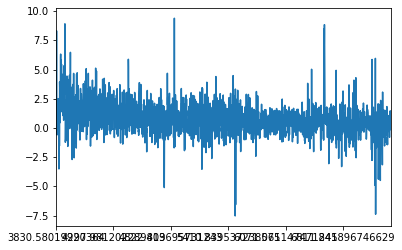

In [8]:
data.iloc[46].plot();

In [9]:
data.shape

(1954, 2919)

In [10]:
16030*100/(data.shape[0]*data.shape[1])

0.28104435591751775

Un 0,28% de todos los valores de frecuencias son negativos, es decir, erróneos (no puede haber cantiddes de flux negativas, es decir "luz" negativa). Esto podría disminuir la confianza en la fiabilidad de los datos del dataset.

Además de haber bastantes valores erróneos, disminuyen mucho el valor mínimo de muchos espectros, haciendo que la estandarización que vamos a hacer después comprima demasiado los valores correctos (lo que hace que casi todos los espectros estandarizados "parezcan iguales".

Por esto, vamos a corregir la situación con la siguiente estrategia:

* Se eliminarán aquellos espectros que tengan dos o más valores negativos (se considerará que ha existido algún error de lectura que puede comprometer la fiabilidad de todo el espectro).
* En los restantes, se cambiará el único valor negativo por el valor correspondiente al continuum, tomando como tal el valor de la media móvil de 20 periodos en ese punto.

In [11]:
# Eliminamos los espectros con dos o más valores negativos
for i in negativos:
    if i[1]>1:
        data.drop(i[0], axis=0, inplace=True)
data.shape       

(1563, 2919)

In [12]:
# Y ahora tratamos los espectros con un solo valor negativo. En estos casos, esa frecuencia tendrá el valor de
# flux mínimo del espectro

# Función recogida en StackOverFlow. Devuelve el valor de posición en el array más cercano al "target"
# Entradas: A, el array a considerar, y el target o valor a buscar.
# En este caso, hay que tener en cuenta que la frecuencia a buscar es el índice en el dataset
def find_closest(A, target): 
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx


# En esta función se calcula la media móvil con un número variable de peridos. Los parámetros de entrada son:
# - espectro, la pd.Serie con el espectro completo a corregir. Tiene como índice la frecuencia.
# - frecuencia, el valor de la frecucncia cuyo flux es negativo. Se corresponde con el mínimo de la "función
#   espectro". Debe llegar como float.
# - periodo, el de la media móvila considerar. Se tiene 20 por defecto (se ajusta bien al espectro medio)
def media_movil(espectro, frecuencia, periodo = 20):
    sma = espectro.rolling(periodo).mean() # sma es la media móvil de todo el espectro
    # Calculamos el valor de sma en la frecuencia dada
    if frecuencia < float(sma.index[periodo]):   # La Serie de sma no tiene valores para los primeros 20 valores
        frecuencia = float(sma.index[periodo])
    indice_sma = pd.to_numeric(sma.index)
    
    # Por alguna razón al tratar los índices y convertirlos de str a float, se producen errores al reconocer valores
    # en casos contados. Para evitarlo, tomamos el valor de frecuencia más cercano
    if frecuencia in indice_sma:
        # Tomamos como valor del flux el de la media móvil en la frecuencia problemática 
        return sma[indice_sma==frecuencia]
    else:
        # Es en estos casos cuando surge el error: tomamos el valor de la siguiente frecuencia a la problemática
        print("¡No esta!")
        frecuencia = float(sma.index[find_closest(indice_sma, frecuencia)+1])
        print(frecuencia)
        return sma[indice_sma==frecuencia]
    

In [13]:
# Aquí corregimos los valores de flux negativos por los de la media móvil, con la ayuda de la función definida
for i in range(len(data)):
    if any(data.iloc[i] < 0):
        data.iloc[i][data.iloc[i].index==data.iloc[i].idxmin()] = media_movil(data.iloc[i], float(data.iloc[i].idxmin()))[0]

¡No esta!
7361.470036745908
¡No esta!
5070.660165887807
¡No esta!
4880.5033101925765


In [14]:
data.to_csv("./espectros_2k_sin_negativos.csv", index=False)

Para luego entrenar los modelos y tener un set de test para las medidas de accuracy, dividimos el dataset en train y test (nos vale un 15% para el test). Recordemos que estamos usando un aprendizaje no supervisado y no tenemos etiquetas.

In [15]:
espectros_train, espectros_test, _, _ = train_test_split(data, data, test_size=0.15, random_state=21)

Ahora podemos seguir con el proceso, primero estandarizando el dataset

In [16]:
scaler = MinMaxScaler() # = np.array(data.apply(lambda x: (x-x.min()) / (x.max()-x.min())))
scaler.fit(espectros_train)
espectros_train_scaled = pd.DataFrame(scaler.transform(espectros_train), 
                               columns=espectros_train.columns,
                               index=espectros_train.index)
espectros_test_scaled = pd.DataFrame(scaler.transform(espectros_test),
                             columns=espectros_test.columns,
                             index=espectros_test.index)

# Esta es la versiós estandarizada de todo el dataset para comparaciones posteriores
espectros_scaled = pd.DataFrame(scaler.transform(data), 
                               columns=data.columns,
                               index=data.index)
espectros_train_scaled.head()

,3830.58019920364,3831.4614191445135,3832.344945685447,3833.2265716039287,3834.110505185121,3834.992537268245,3835.8768780772193,3836.7593165121057,3837.641957950795,3838.526909710328,3839.4099577815086,3840.2953172378966,3841.178772128906,3842.0645394699764,3842.948401368234,3843.832466597762,3844.718845874915,3845.6033183928735,3846.490106024541,3847.3749860185694,3848.2621821928774,3849.1474698507,3850.032961167784,3850.9207702652907,3851.8066695278053,3852.694887638543,3853.581195034427,3854.4698223468267,3855.356538064109,3856.2434577691774,3857.1326989934832,3858.0200273020373,3858.909678199355,3859.797415299641,3860.6874760587043,3861.575622139053,3862.4660929486854,3863.354648197511,3864.243407857304,3865.134493852431,3866.023662963378,3866.9151594814007,3867.804738232137,3868.6966454621834,3869.586634041426,3870.476827361373,3871.369350769271,3872.2599542008575,3873.152888793867,3874.0439025260325,...,7415.912601563356,7417.618622511728,7419.329108983227,7421.035915894642,7422.747190386448,7424.4547836229995,7426.162769689128,7427.875226422096,7429.583999356597,7431.2972450175685,7433.00680518295,7434.7208401353855,7436.431187894326,7438.141929116521,7439.857148217194,7441.568677577057,7443.284686878358,7444.997004738985,7446.713804604958,7448.426911329613,7450.14041215222,7451.858398076581,7453.572688308204,7455.291465707865,7457.006545712186,7458.726114951779,7460.441985092645,7462.158249967181,7463.879007178399,7465.596062735349,7467.317612698597,7469.03545930223,7470.757802382729,7472.476440397477,7474.19547378264,7475.919006751083,7477.638832094114,7479.36315909338,7481.083776759128,7482.8088981550245,7484.530308508518,7486.252114870202,7487.978428073448,7489.701027670507,7491.42813618543,7493.1515293833045,7494.879433576302,7496.603620740605,7498.328204551902,7500.057302474759
1515,0.609595,0.583632,0.722986,0.516955,0.383090,0.537671,0.639145,0.547752,0.572901,0.565917,0.616575,0.734738,0.662285,0.676618,0.839499,0.941513,0.725880,0.601166,0.545068,0.544806,0.439502,0.808418,0.902901,0.703763,0.630870,0.770349,0.960061,0.670346,0.873329,1.000000,0.813101,0.738564,0.737898,0.714576,0.985970,0.872083,0.718941,0.759879,0.744028,0.662251,0.623608,0.629839,0.451470,0.410121,0.433419,0.446923,0.428367,0.565258,0.596806,0.805781,...,0.052640,0.063553,0.090047,0.082028,0.073867,0.066959,0.070363,0.081161,0.081978,0.078049,0.097152,0.073371,0.076452,0.073112,0.105189,0.125627,0.119197,0.080029,0.075113,0.076065,0.049406,0.068269,0.093219,0.112290,0.066241,0.086248,0.085564,0.092888,0.124506,0.063084,0.062421,0.077233,0.084873,0.083011,0.101859,0.073889,0.069975,0.068575,0.064226,0.062196,0.052137,0.074854,0.080143,0.070084,0.088573,0.127122,0.116424,0.082451,0.098965,0.069214
497,0.121958,0.115751,0.114736,0.162028,0.190130,0.122087,0.082002,0.040682,0.072661,0.138495,0.201501,0.248390,0.189142,0.130475,0.104205,0.130574,0.151581,0.151905,0.116047,0.148560,0.145596,0.174001,0.090203,0.071348,0.101079,0.131196,0.087869,0.152734,0.184648,0.209811,0.170624,0.127532,0.074321,0.059689,0.065359,0.118509,0.166631,0.177639,0.180300,0.072724,0.038033,0.037748,0.058241,0.072407,0.047028,0.016895,0.096407,0.218367,0.094072,0.196684,...,0.312738,0.284084,0.250958,0.253726,0.287861,0.355817,0.333168,0.308504,0.356377,0.350253,0.356251,0.385201,0.384535,0.347087,0.354690,0.364359,0.304719,0.246318,0.259825,0.326629,0.422566,0.441401,0.355269,0.409689,0.270735,0.277041,0.384471,0.355157,0.405037,0.331143,0.306436,0.377871,0.340012,0.282175,0.285916,0.243630,0.246116,0.273664,0.352932,0.347852,0.260161,0.348564,0.354940,0.309735,0.317407,0.323856,0.289194,0.289911,0.325260,0.303481
476,0.101923,0.142373,0.199622,0.178793,0.143416,0.102384,0.129215,0.113745,0.131148,0.150123,0.125042,0.091009,0.143923,0.228207,0.162958,0.122430,0.189604,0.211971,0.208732,0.227760,0.139766,0.202749,0.167830,0.080942,0.061933,0.120636,0.154785,0.181882,0.203035,0.221167,0.117942,0.104834,0.130073,0.125811,0.161536,0.164258,0.180061,0.154449,0.139126,0.164

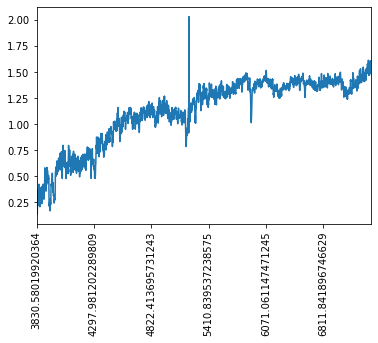

In [17]:
# Un espectro original cualquiera (el de índice 16 en este caso)
espectros_train.iloc[16].plot();
plt.xticks(rotation=90);

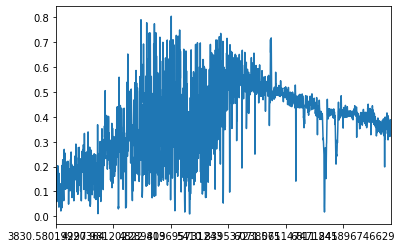

In [18]:
# El mismo espectro, pero con valores estandarizados
espectros_train_scaled.iloc[16].plot();

Después vamos a definir distintas posibilidades a probar con dim_latente y ver cual es la que da mejores resultados posteriormente al pasar por DBSCAN y sacar Silhouette coefficient. Sin embargo, primero vamos a hacer algo extremo y es definir n_latente como 2. Con ello, podremos representar bidimensionalmente la nube de espectros.

In [38]:
dim_latente = 2

In [39]:
espectros_train_scaled.shape

(1328, 2919)

In [40]:
dim_input = espectros_train_scaled.shape[1]
dim_input

2919

In [22]:
# Función para mostrar la gráfica de evolución de train loss y val loss en cada epoch durante el entrenamiento 
def grafica_loss(modelo, n_epochs):
    loss = modelo.history.history['loss']
    val_loss = modelo.history.history['val_loss']
    epochs = range(n_epochs)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Test loss')
    plt.title('Error de Training y Test')
    plt.legend()

### Autoencoder deep

Se ha probado com 'mse', pero parece que los mejores resultados siguen dándose con un error de tipo 'binary_crossentropy'. Dado que los valores de entrada siempre son positivos, no tenía sentido usar selu en vez de relu como función de activación. La optimización sigue siendo "adadelta" ("ada" da resultados mucho peores). En la capa de salida, la activación debe ser con sigmoid (otras provocan desestabilización de la red).

En cuanto al número de epochs, se pone 40, dado que la mejora en la parte final empieza ya a degradarse (ver gráfica de loss). Además, si nos pasamos en número de epochs, la red se desestabiliza en muchas ocasiones.

En cuanto a la arquitectura de capas ocultas, no parece que el rendimiento varíe mucho al disminuirlo considerablemente, incluso quitando una capa en el encoder y su simétrica en el decoder.

Train on 1328 samples, validate on 235 samples
Epoch 1/40
1328/1328 [==============================] - 4s 3ms/step - loss: 0.6930 - acc: 7.5275e-04 - val_loss: 0.6928 - val_acc: 0.0000e+00
Epoch 2/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6926 - acc: 7.5327e-04 - val_loss: 0.6924 - val_acc: 0.0000e+00
Epoch 3/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6919 - acc: 7.5972e-04 - val_loss: 0.6911 - val_acc: 0.0000e+00
Epoch 4/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6889 - acc: 7.6436e-04 - val_loss: 0.6841 - val_acc: 0.0000e+00
Epoch 5/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6694 - acc: 7.7210e-04 - val_loss: 0.6471 - val_acc: 0.0000e+00
Epoch 6/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6339 - acc: 7.3934e-04 - val_loss: 0.6268 - val_acc: 0.0000e+00
Epoch 7/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6252 - acc: 7.5172e-04 

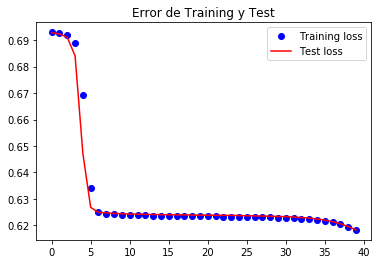

In [41]:
epochs = 40

if entrenar:
    input = Input(shape=((dim_input, )))
    encoded = Dense(1000, activation='relu')(input)
    encoded = Dense(500, activation='relu')(encoded)
    encoded = Dense(dim_latente, activation='relu')(encoded)
    decoded = Dense(500, activation='relu')(encoded)
    decoded = Dense(1000, activation='relu')(decoded)
    decoded = Dense(dim_input, activation='sigmoid')(decoded)

    # Modelo para obtener el autoencoder completo
    autoencoder_deep = Model(input, decoded)
    
    # Modelo para obtener el espacio latente
    encoder = Model(input, encoded)
    
    autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])
    autoencoder_deep.fit(espectros_train_scaled, espectros_train_scaled,
                epochs=epochs,
                batch_size=64,
                shuffle=True,
                validation_data=(espectros_test_scaled, espectros_test_scaled))  
    grafica_loss(autoencoder_deep, epochs)
    autoencoder_deep.save('model_deep2k_lat_2.h5')
    encoder.save("model_encoder_deep2k_lat_2.h5")
    

else:
    autoencoder_deep = load_model('model_deep2k_lat_2.h5')
    encoder = load_model("model_encoder_deep2k_lat_2.h5")
    
autoencoder_deep.summary()

In [42]:
# Este es el modelo con el que obtenemos la representación latente de los espectros del test_set
espectro_encoded = encoder.predict(espectros_test_scaled) 

# Esta es la salida del autoencoder, para comprobar si se parece a la entrada
espectro_decoded = autoencoder_deep.predict(espectros_test_scaled) 

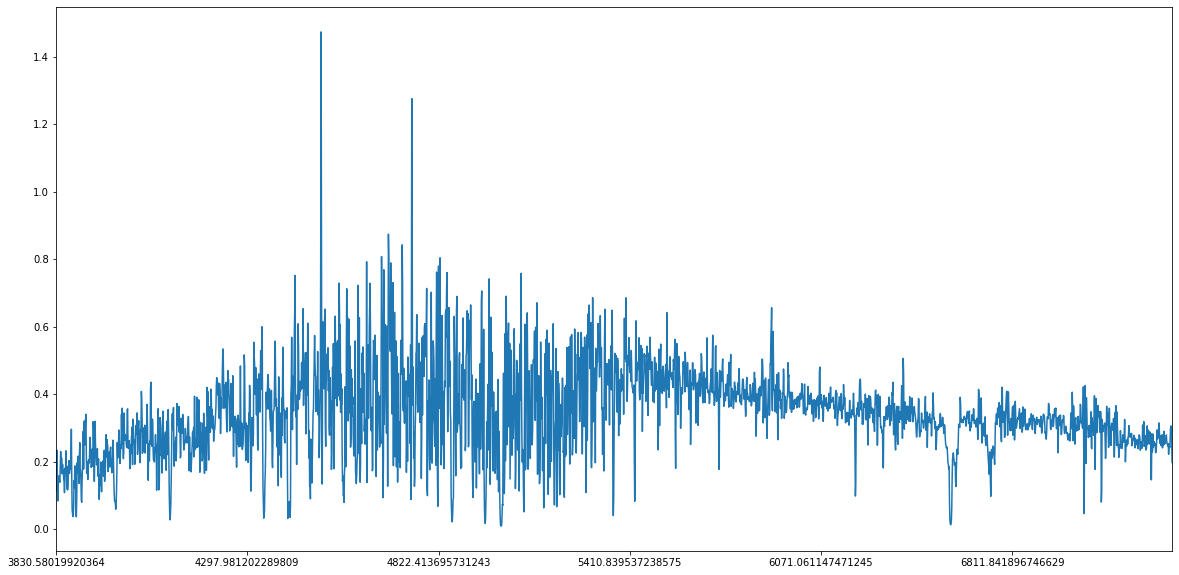

In [43]:
# Un espectro de entrada cualquier (en esta ocasión el de índice 100). recordemos que está estandarizado
plt.figure(figsize=(20, 10))
espectros_test_scaled.iloc[100].plot();

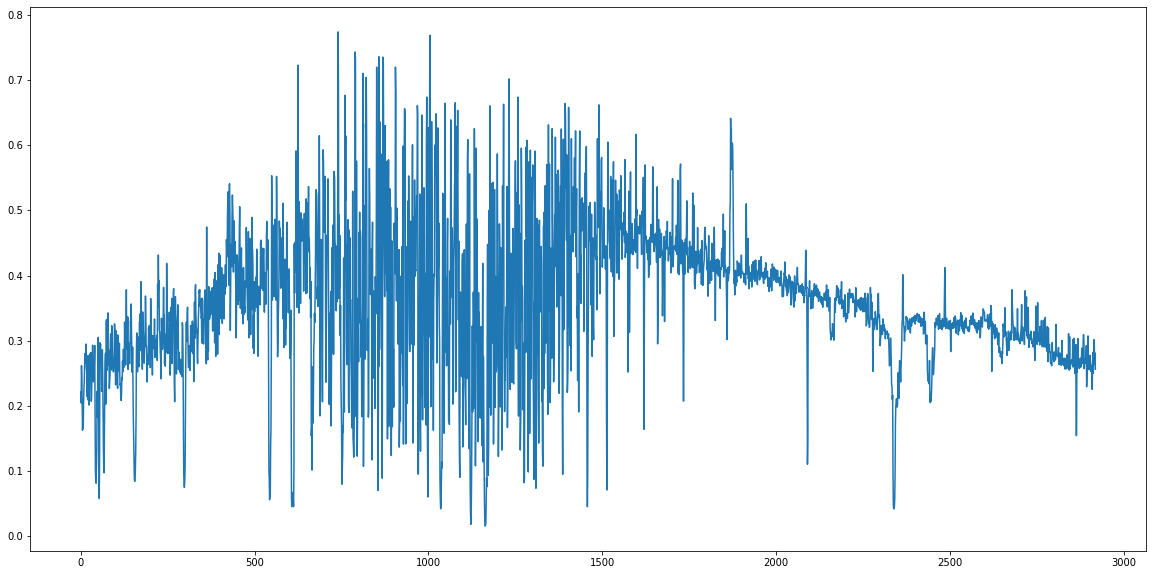

In [44]:
# Su reproducción por el decoder
plt.figure(figsize=(20, 10))
plt.plot(espectro_decoded[100]);

Hay que tener en cuenta que el autoencoder solo va a dar valores entre 0 y 1 y que en algunos casos la imagen de entrada tiene valores por encima de 1 (es decir, las escalas de las dos gráficas de arriba son diferentes, pero podemos fijarnos en que, aparte de los picos por encima de 1, el resto es muy parecido).

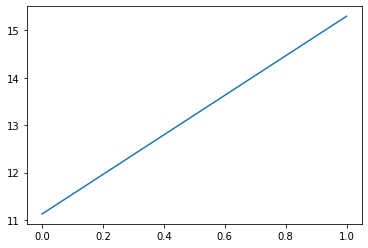

In [45]:
# La representación latente del mismo espectro
plt.plot(espectro_encoded[100]);

Por tanto vamos a usar el modelo anterior sobre todos los espectros de que disponemos (partiendo de todo el dataset estandarizado) y recoger la representanción latente de los mismos.

In [46]:
espectros_latentes = encoder.predict(espectros_scaled)

In [47]:
espectros_latentes

array([[13.262818 , 12.463183 ],
       [12.720391 , 13.153925 ],
       [ 6.8618574, 19.055    ],
       ...,
       [12.342624 , 14.806227 ],
       [11.953026 , 13.964599 ],
       [12.270696 , 14.491201 ]], dtype=float32)

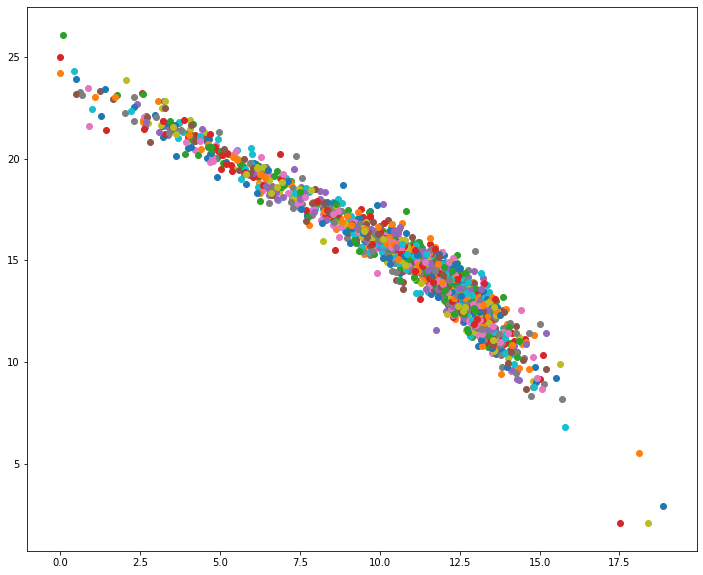

In [48]:
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for i in range(len(espectros_latentes)):
    ys = espectros_latentes[i][0]
    zs = espectros_latentes[i][1]
    ax.scatter(ys, zs)


Con más dimensiones pasará algo parecido. Tenemos una nube de la que es difícil sacar clusters, pero si podemos sacar outliers.

Ahora vamos a volver a entrenar el modelo del autoencoder, pero esta vez creando una especie de pipeline en la que probemos con distintos valores de dim_latente. Después, con el espacio latente resultante, aplicamos Silhouette para un rango de número de clusters y qué puntuación sale. Repetimos esta clusterización varias veces para cada vez y finalmente cogemos la media de estas repeticiones (así podremos combatir la aleatoriedad del proceso).

Con ello, podremos escoger mejor el dim_latentes óptimo (donde el valor de Silhouette sea máximo).

In [56]:
grid_dim_latente = [3, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 500]
epochs = 40
historial = []
num_max_clusters = 10 
intentos_clustering = 40

In [57]:
for dim_latente in grid_dim_latente:
    print("\n")
    print("****** Dimensión del espacio latente:", dim_latente)
    
    input = Input(shape=((dim_input, )))
    encoded = Dense(1000, activation='relu')(input)
    encoded = Dense(500, activation='relu')(encoded)
    encoded = Dense(dim_latente, activation='relu')(encoded)
    decoded = Dense(500, activation='relu')(encoded)
    decoded = Dense(1000, activation='relu')(decoded)
    decoded = Dense(dim_input, activation='sigmoid')(decoded)

    # Modelo para obtener el autoencoder completo
    autoencoder_deep = Model(input, decoded)
    
    # Modelo para obtener el espacio latente
    encoder = Model(input, encoded)
    
    autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])
    autoencoder_deep.fit(espectros_train_scaled, espectros_train_scaled,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(espectros_test_scaled, espectros_test_scaled))  
  
    espectros_latentes = encoder.predict(espectros_train_scaled)
    
    # Calculamos Silhouette    
    print("Calculando índices Silhouette para " + str(dim_latente) + " variables")

    coefs_para_dim_n = np.zeros((num_max_clusters, intentos_clustering, 3))
    for k in range(2, num_max_clusters, 1):
        print ("Probando GMM para " + str(k) + " clusters")
        # Repetimos el entrenamiento de clustering varias veces por la naturaleza aleatoria del proceso.
        # Luego cogemos la media de todos los intentos
        for intento in range(intentos_clustering): 
            clustering = GaussianMixture(n_components=k)
            cluster_labels = clustering.fit_predict(espectros_latentes)

            silhouette_avg = silhouette_score(espectros_latentes, cluster_labels)
            coefs_para_dim_n[k][intento] = (dim_latente, k, silhouette_avg)

    # Con este formato podremos recuperar el top 3 para todos los valores de las dimensiones que probemos
    historial.append(sorted(coefs_para_dim_n.mean(axis=1), key=lambda x: x[2], reverse= True)[:1]) 
    
print ("¡Terminado!")
    
   



****** Dimensión del espacio latente: 3
Train on 1328 samples, validate on 235 samples
Epoch 1/40
1328/1328 [==============================] - 4s 3ms/step - loss: 0.6930 - acc: 7.6720e-04 - val_loss: 0.6929 - val_acc: 0.0000e+00
Epoch 2/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6928 - acc: 7.6643e-04 - val_loss: 0.6925 - val_acc: 0.0000e+00
Epoch 3/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6922 - acc: 7.6024e-04 - val_loss: 0.6917 - val_acc: 0.0000e+00
Epoch 4/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6910 - acc: 7.5791e-04 - val_loss: 0.6897 - val_acc: 0.0000e+00
Epoch 5/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6876 - acc: 7.5998e-04 - val_loss: 0.6836 - val_acc: 0.0000e+00
Epoch 6/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6778 - acc: 7.5198e-04 - val_loss: 0.6673 - val_acc: 0.0000e+00
Epoch 7/40
1328/1328 [==============================] - 1s 

1328/1328 [==============================] - 2s 1ms/step - loss: 0.6240 - acc: 7.5250e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 16/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6239 - acc: 7.5224e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 17/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6238 - acc: 7.5250e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 18/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6238 - acc: 7.5301e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 19/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6237 - acc: 7.5301e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 20/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6237 - acc: 7.5404e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 21/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6237 - acc: 7.5430e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 22/40

Epoch 30/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6231 - acc: 7.5714e-04 - val_loss: 0.6235 - val_acc: 0.0000e+00
Epoch 31/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6230 - acc: 7.5869e-04 - val_loss: 0.6235 - val_acc: 0.0000e+00
Epoch 32/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6229 - acc: 7.6024e-04 - val_loss: 0.6234 - val_acc: 0.0000e+00
Epoch 33/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6228 - acc: 7.6178e-04 - val_loss: 0.6233 - val_acc: 0.0000e+00
Epoch 34/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6227 - acc: 7.6436e-04 - val_loss: 0.6232 - val_acc: 0.0000e+00
Epoch 35/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6226 - acc: 7.6772e-04 - val_loss: 0.6231 - val_acc: 0.0000e+00
Epoch 36/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6224 - acc: 7.7107e-04 - val_loss: 0.6229 - val_acc: 0.0000e+00

1328/1328 [==============================] - 2s 1ms/step - loss: 0.6919 - acc: 7.5972e-04 - val_loss: 0.6911 - val_acc: 0.0000e+00
Epoch 3/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6899 - acc: 7.6668e-04 - val_loss: 0.6876 - val_acc: 0.0000e+00
Epoch 4/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6841 - acc: 7.4785e-04 - val_loss: 0.6770 - val_acc: 0.0000e+00
Epoch 5/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6676 - acc: 7.4140e-04 - val_loss: 0.6535 - val_acc: 0.0000e+00
Epoch 6/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6437 - acc: 7.5275e-04 - val_loss: 0.6339 - val_acc: 0.0000e+00
Epoch 7/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6299 - acc: 7.5327e-04 - val_loss: 0.6271 - val_acc: 0.0000e+00
Epoch 8/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6258 - acc: 7.4940e-04 - val_loss: 0.6254 - val_acc: 0.0000e+00
Epoch 9/40
1328/1

Epoch 17/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6233 - acc: 7.5585e-04 - val_loss: 0.6236 - val_acc: 0.0000e+00
Epoch 18/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6231 - acc: 7.5611e-04 - val_loss: 0.6235 - val_acc: 0.0000e+00
Epoch 19/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6230 - acc: 7.5688e-04 - val_loss: 0.6233 - val_acc: 0.0000e+00
Epoch 20/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6228 - acc: 7.5662e-04 - val_loss: 0.6233 - val_acc: 0.0000e+00
Epoch 21/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6226 - acc: 7.5946e-04 - val_loss: 0.6230 - val_acc: 0.0000e+00
Epoch 22/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6224 - acc: 7.6024e-04 - val_loss: 0.6228 - val_acc: 0.0000e+00
Epoch 23/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6222 - acc: 7.6307e-04 - val_loss: 0.6226 - val_acc: 0.0000e+00

Epoch 32/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6183 - acc: 8.2473e-04 - val_loss: 0.6186 - val_acc: 0.0000e+00
Epoch 33/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6175 - acc: 8.4021e-04 - val_loss: 0.6178 - val_acc: 0.0000e+00
Epoch 34/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6166 - acc: 8.6059e-04 - val_loss: 0.6170 - val_acc: 0.0000e+00
Epoch 35/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6158 - acc: 8.8019e-04 - val_loss: 0.6162 - val_acc: 0.0000e+00
Epoch 36/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6150 - acc: 9.0212e-04 - val_loss: 0.6154 - val_acc: 0.0000e+00
Epoch 37/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6143 - acc: 9.1682e-04 - val_loss: 0.6148 - val_acc: 0.0000e+00
Epoch 38/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6136 - acc: 9.3436e-04 - val_loss: 0.6142 - val_acc: 0.0000e+00

1328/1328 [==============================] - 2s 1ms/step - loss: 0.6788 - acc: 7.6746e-04 - val_loss: 0.6684 - val_acc: 0.0000e+00
Epoch 5/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6574 - acc: 7.5869e-04 - val_loss: 0.6436 - val_acc: 0.0000e+00
Epoch 6/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6361 - acc: 7.5946e-04 - val_loss: 0.6298 - val_acc: 0.0000e+00
Epoch 7/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6273 - acc: 7.5611e-04 - val_loss: 0.6260 - val_acc: 0.0000e+00
Epoch 8/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6251 - acc: 7.5275e-04 - val_loss: 0.6250 - val_acc: 0.0000e+00
Epoch 9/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6245 - acc: 7.5275e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 10/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6242 - acc: 7.5121e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 11/40
1328

Epoch 19/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6230 - acc: 7.5843e-04 - val_loss: 0.6233 - val_acc: 0.0000e+00
Epoch 20/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6228 - acc: 7.6075e-04 - val_loss: 0.6232 - val_acc: 0.0000e+00
Epoch 21/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6226 - acc: 7.6359e-04 - val_loss: 0.6230 - val_acc: 0.0000e+00
Epoch 22/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6224 - acc: 7.6488e-04 - val_loss: 0.6228 - val_acc: 0.0000e+00
Epoch 23/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6221 - acc: 7.6694e-04 - val_loss: 0.6225 - val_acc: 0.0000e+00
Epoch 24/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6218 - acc: 7.6926e-04 - val_loss: 0.6222 - val_acc: 0.0000e+00
Epoch 25/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6215 - acc: 7.7236e-04 - val_loss: 0.6218 - val_acc: 0.0000e+00

Epoch 34/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6148 - acc: 9.1631e-04 - val_loss: 0.6152 - val_acc: 0.0000e+00
Epoch 35/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6140 - acc: 9.4210e-04 - val_loss: 0.6147 - val_acc: 0.0000e+00
Epoch 36/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6133 - acc: 9.5939e-04 - val_loss: 0.6139 - val_acc: 0.0000e+00
Epoch 37/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6128 - acc: 9.8028e-04 - val_loss: 0.6135 - val_acc: 0.0000e+00
Epoch 38/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6123 - acc: 0.0010 - val_loss: 0.6129 - val_acc: 0.0000e+00
Epoch 39/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6119 - acc: 0.0010 - val_loss: 0.6130 - val_acc: 0.0000e+00
Epoch 40/40
1328/1328 [==============================] - 2s 2ms/step - loss: 0.6121 - acc: 0.0010 - val_loss: 0.6136 - val_acc: 0.0000e+00
Calculando 

1328/1328 [==============================] - 1s 1ms/step - loss: 0.6380 - acc: 7.5327e-04 - val_loss: 0.6310 - val_acc: 0.0000e+00
Epoch 7/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6282 - acc: 7.4811e-04 - val_loss: 0.6264 - val_acc: 0.0000e+00
Epoch 8/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6255 - acc: 7.5327e-04 - val_loss: 0.6253 - val_acc: 0.0000e+00
Epoch 9/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6247 - acc: 7.5275e-04 - val_loss: 0.6249 - val_acc: 0.0000e+00
Epoch 10/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6244 - acc: 7.5327e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 11/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6242 - acc: 7.5275e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 12/40
1328/1328 [==============================] - 1s 1ms/step - loss: 0.6240 - acc: 7.5404e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 13/40
13

In [58]:
historial

[[array([3.        , 2.        , 0.47832639])],
 [array([5.        , 2.        , 0.46549472])],
 [array([10.        ,  2.        ,  0.47192609])],
 [array([20.        ,  2.        ,  0.61464369])],
 [array([50.        ,  3.        ,  0.17141157])],
 [array([100.        ,   2.        ,   0.57265532])],
 [array([150.       ,   2.       ,   0.6546114])],
 [array([200.        ,   2.        ,   0.65698183])],
 [array([250.        ,   2.        ,   0.64879853])],
 [array([300.        ,   2.        ,   0.65348911])],
 [array([350.        ,   2.        ,   0.65946558])],
 [array([400.        ,   2.        ,   0.64951678])],
 [array([500.        ,   2.        ,   0.64694297])]]

Con estos resultados, lo primero que vemos es que el número óptimo de clusters es 2 en todos los casos (y porque es el valor mínimo de clusters que hemos impuesto).

Después, resulta sorprendente la alta puntuación para valores muy altos de dimensión latente, aunque ya en 400 empieza a degradarse el resultado. De todas formas, las diferencias entre los distintos valores son mínimas, con lo que, en realidad, cualquier valor sería válido.

El valor óptimo según este análisis es 350 variables y por tanto será este el valor que utilizaremos después con los algoritmos de clustering (se ha repetido este análisis múltiples ocasiones, con resultados distintos, pero donde el máximo del coeficiente silhouette siempre está entre las 150 y las 300 dimensiones).

Volvemos a entrenar la red, esta vez con nuestro valor óptimo de variables en el espacio latente.

In [59]:
dim_latente = 350
epochs = 40

input = Input(shape=((dim_input, )))
encoded = Dense(1000, activation='relu')(input)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(dim_latente, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(encoded)
decoded = Dense(1000, activation='relu')(decoded)
decoded = Dense(dim_input, activation='sigmoid')(decoded)

autoencoder_deep = Model(input, decoded)
encoder = Model(input, encoded)
    
autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])
autoencoder_deep.fit(espectros_train_scaled, espectros_train_scaled,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(espectros_test_scaled, espectros_test_scaled))  
  
espectros_latentes = encoder.predict(espectros_scaled)

Train on 1328 samples, validate on 235 samples
Epoch 1/40
1328/1328 [==============================] - 5s 4ms/step - loss: 0.6927 - acc: 7.4759e-04 - val_loss: 0.6920 - val_acc: 0.0000e+00
Epoch 2/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6912 - acc: 7.5224e-04 - val_loss: 0.6899 - val_acc: 0.0000e+00
Epoch 3/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6879 - acc: 7.4914e-04 - val_loss: 0.6840 - val_acc: 0.0000e+00
Epoch 4/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6780 - acc: 7.5998e-04 - val_loss: 0.6672 - val_acc: 0.0000e+00
Epoch 5/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6563 - acc: 7.4398e-04 - val_loss: 0.6428 - val_acc: 0.0000e+00
Epoch 6/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6356 - acc: 7.5121e-04 - val_loss: 0.6297 - val_acc: 0.0000e+00
Epoch 7/40
1328/1328 [==============================] - 2s 1ms/step - loss: 0.6272 - acc: 7.5327e-04 

## Aplicación de algoritmos de clustering

## 1.- DBSCAN

DBSCAN tiene dos parámetros:

* eps, que es la distancia mínima para considerar a dos muestras como del mismo cluster
* min_samples, que es el número de muestras mínimo que debe contener un cluster.

Cuando una muestra no llegue al número mínimo del clusters, se considerará outlier y DBSCAN la etiquetará como -1.

Para ajustar mejor el parámetro eps, vamos a ir probando con un bucle que recorra eps desde 0,1 a 2 y visualizar los resultados. Intentamos maximizar el número de clusters sin que se dispare el número de outliers.

In [60]:
num_clusters = []
num_outliers = []
rango = np.arange (0.1, 5, 0.01)
for eps in rango:
    np.random.seed(21)
    clustering = DBSCAN(eps=eps, min_samples=2, n_jobs=-1).fit(espectros_latentes)
    labels = np.unique(clustering.labels_, return_counts=True)
    num_clusters.append(len(labels[0]))
    num_outliers.append(labels[1][0])
                        

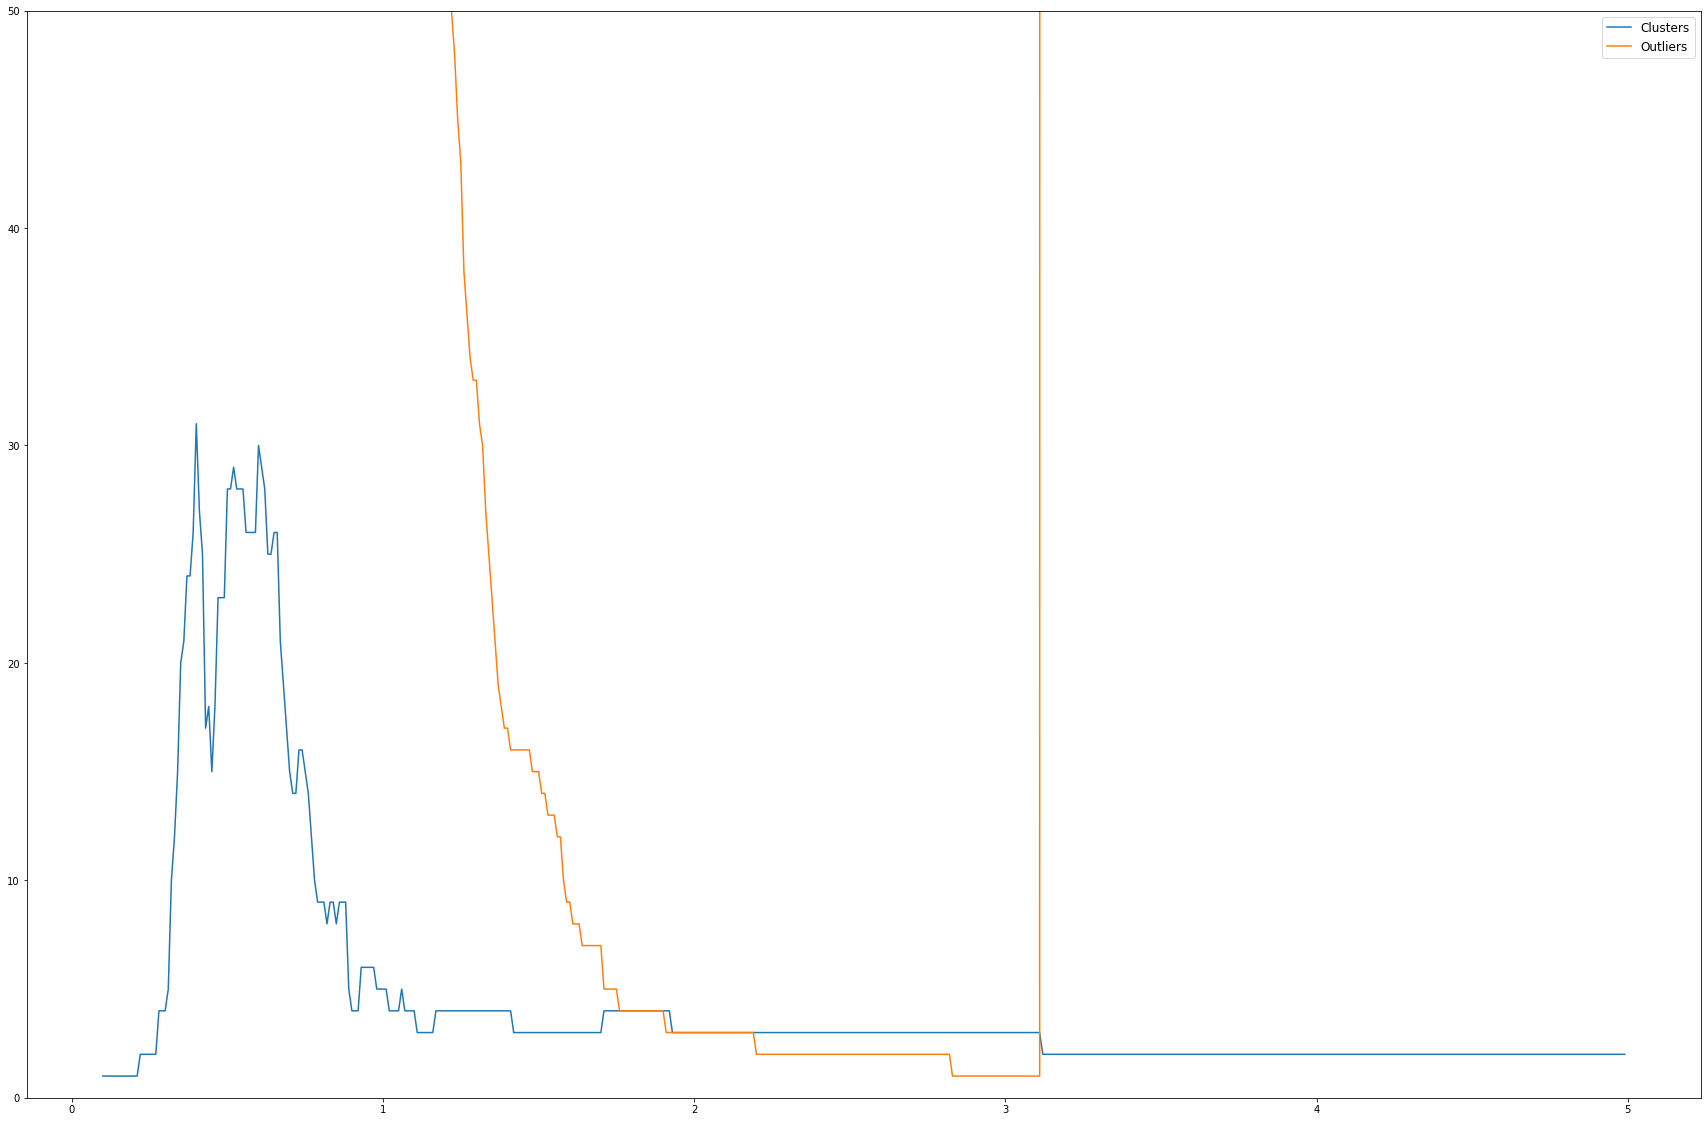

In [61]:
plt.figure(figsize=(30, 20));
plt.plot(rango, num_clusters, label="Clusters");
plt.plot(rango, num_outliers, label="Outliers");
plt.ylim(top=50, bottom=0);
plt.legend(prop={'size': 12});

In [62]:
clustering = DBSCAN(eps=2, min_samples=2, n_jobs=-1).fit(espectros_latentes)
labels = np.unique(clustering.labels_, return_counts=True)
labels

(array([-1,  0,  1]), array([   3, 1558,    2]))

Como ocurre en varios experimentos con DBSCAN (o GMM), y como avanzaba la representación gráfica realizada con el modelo de 3 variables en el espacio latente, salen un número bajo de clusters (sin permitir que se dispare el número de outliers), y todas las muestras caen en uno solo de los clusters, excepto 2 o 3 que caen en los otros.

Es decir, no vamos a obtener clusters significativos, pero podemos sacar outliers con cierta facilidad (en este caso salen 3, aunque podríamos ajustar el valor de eps para obtener el número que consideremos más adecuado). Otra cosa es que estos outliers sean interesantes, lo  que deberemos exponer al juicio del IAC.

#### Visualización de clusters resultantes

Vamos a dibujar los 10 primeros ejemplos dentro de cada cluster, representado primero los espectros latentes, luego los estandarizados y por último los originales sin estandarizar.

Lo haremos igual para cada cluster.

In [63]:
clusters = []
for i in range(-1,len(labels[0]), 1): # Empezamos en -1 para coger también los outliers, en el índice 0 del array labels
    clusters.append(np.where(clustering.labels_==i))

In [64]:
clusters

[(array([  21,  119, 1193]),),
 (array([   0,    1,    2, ..., 1560, 1561, 1562]),),
 (array([ 940, 1208]),),
 (array([], dtype=int64),)]

In [65]:
# Función para representar las tres gráficas de varios elementos de un cluster (stack vertical)

def grafica_cluster(cluster, num_graf=10):
    print("Cluster: ", cluster)
    
    plt.figure(figsize=(20, 50))

    # Si el cluster tiene menos de 10 unidades, dará error al intentar representarlo. Corregimos esto.
    if len(clusters[cluster][0]) < num_graf:
        num_graf2 = len(clusters[cluster][0])
    else:
        num_graf2 = num_graf
    
    for n in range(num_graf2):
        # Gráficas de los espectros latentes
        ax = plt.subplot(num_graf2*3, 1, n+1)
        plt.plot(espectros_latentes[clusters[cluster][0][n-1]])
        plt.title("Latentes")
        # Gráficas de los espectros originales estandarizados
        bx = plt.subplot(num_graf2*3, 1, (n+1+num_graf2))
        espectros_scaled.iloc[clusters[cluster][0][n-1]].plot()
        plt.title("Estandarizados")
        # Gráficas de los espectros originales sin estandarizar
        cx = plt.subplot(num_graf2*3, 1, (n+1+(num_graf2*2)))
        data.iloc[clusters[cluster][0][n-1]].plot()
        plt.title("Sin estandarizar")
        plt.savefig('espectros.png')
    

In [66]:
# Función para representar las tres gráficas de varios elementos de un cluster (stack horizontal)

def grafica_cluster2(cluster, num_graf=10):
    print("Cluster: ", cluster)
    
    # Si el cluster tiene menos de 10 unidades, dará error al intentar representarlo. Corregimos esto.
    if len(clusters[cluster][0]) < num_graf:
        num_graf2 = len(clusters[cluster][0])
    else:
        num_graf2 = num_graf
    
    for n in range(1, num_graf2+1):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(17, 20)
        # Gráficas de los espectros latentes
        ax1 = plt.subplot(num_graf2, 3, (n*3)-2)
        ax1.plot(espectros_latentes[clusters[cluster][0][n-1]])
        plt.title("Latentes")
        # Gráficas de los espectros originales estandarizados
        ax2 = plt.subplot(num_graf2, 3, (n*3)-1)
        espectros_scaled.iloc[clusters[cluster][0][n-1]].plot()
        plt.title("Estandarizados")
        # Gráficas de los espectros originales sin estandarizar
        ax3 = plt.subplot(num_graf2, 3, (n*3))
        data.iloc[clusters[cluster][0][n-1]].plot()
        plt.title("Originales")
        #plt.savefig('espectros.png')

Cluster:  0


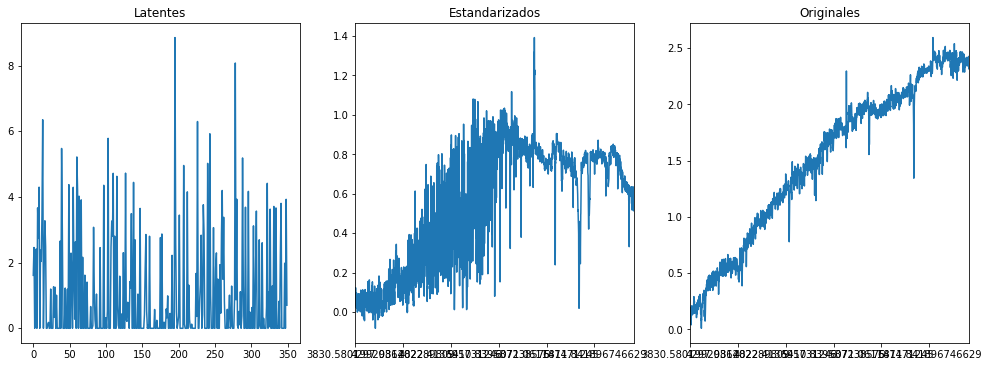

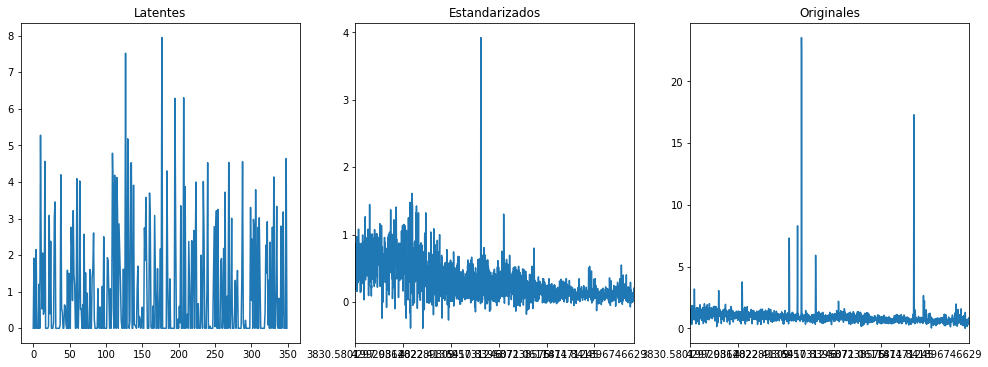

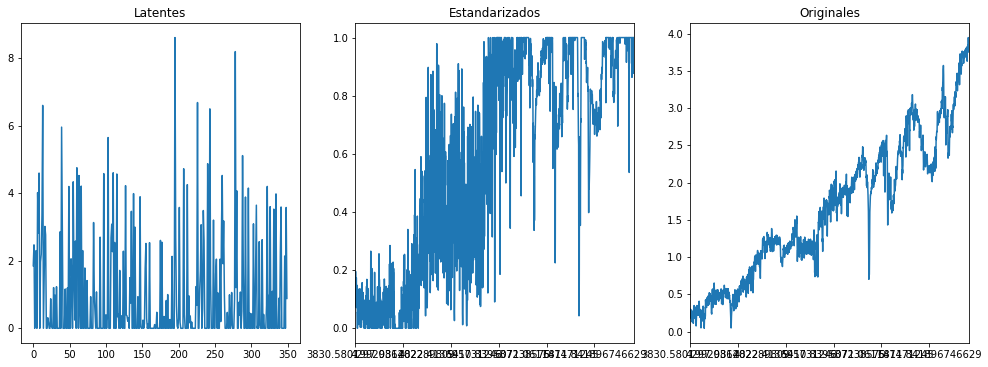

In [67]:
# Outliers (label = -1, index en array "cluster" = 0)
grafica_cluster2(0)

Cluster:  1


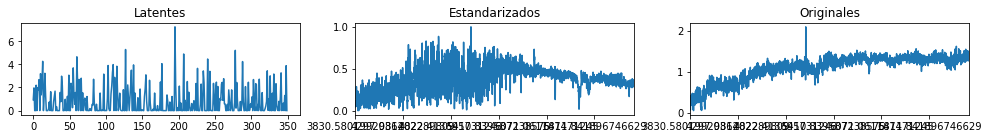

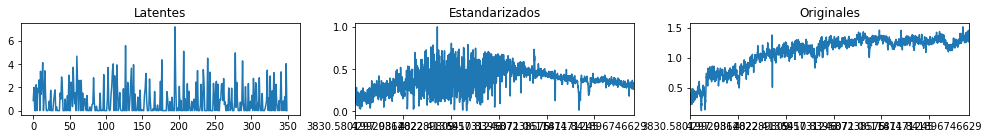

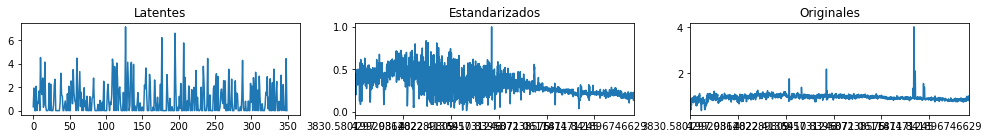

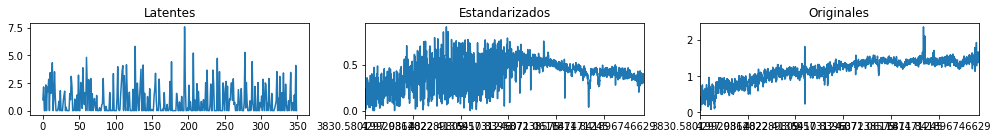

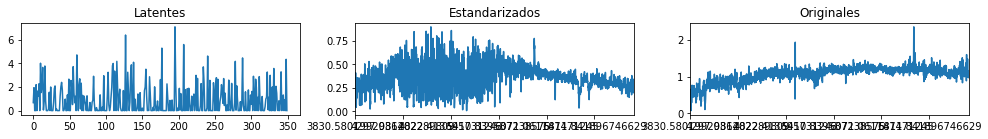

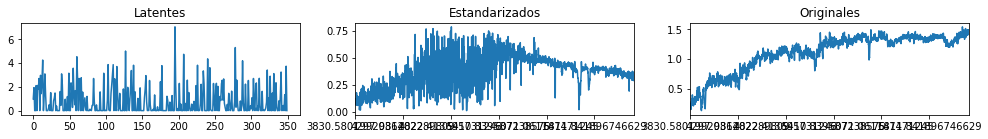

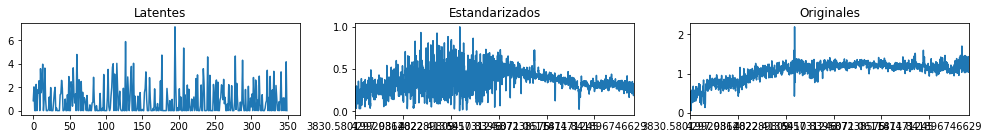

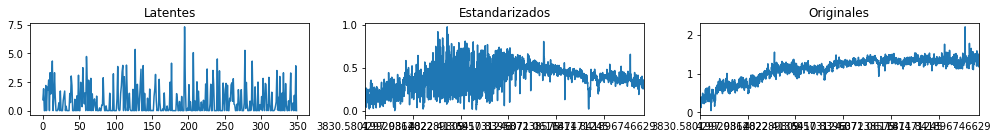

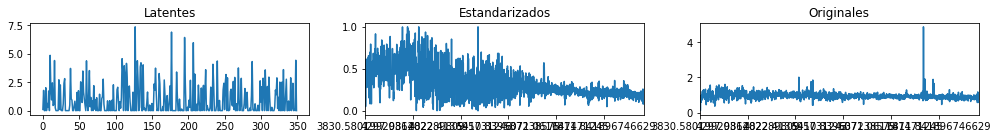

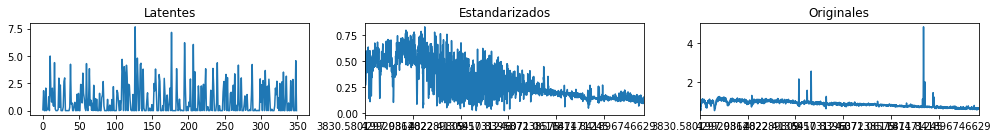

In [68]:
# Grupo label = 0 (index 1)
grafica_cluster2(1)

Cluster:  2


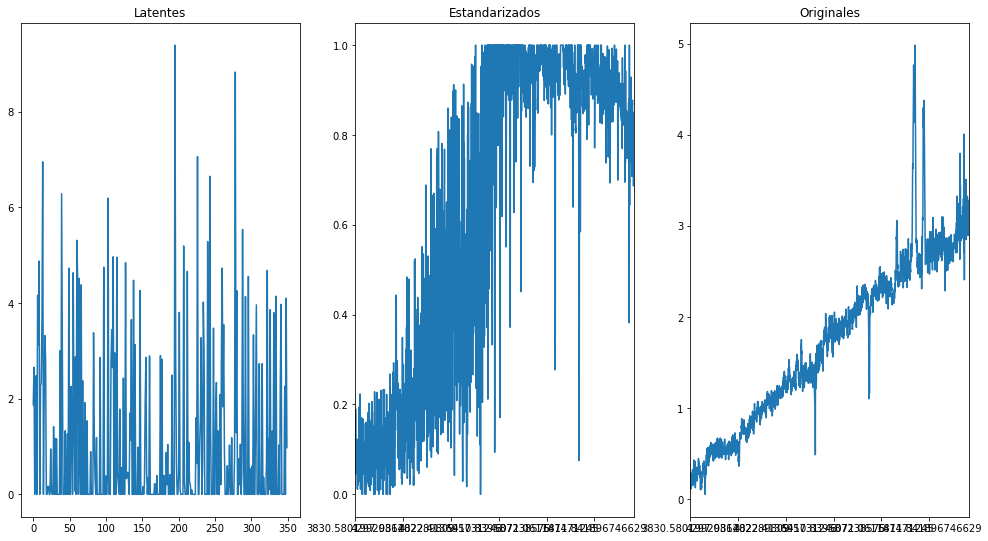

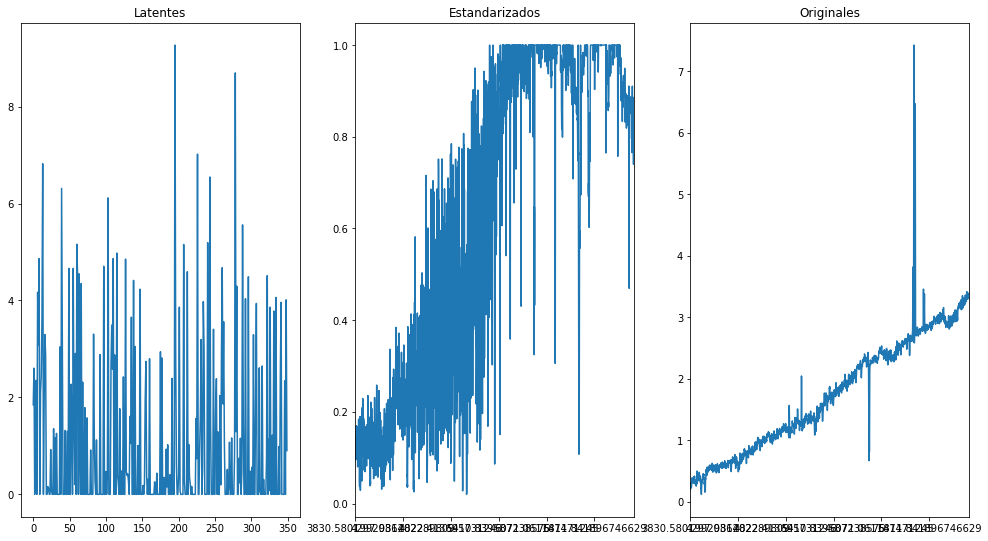

In [69]:
# Grupo label = 1 (index 2)
grafica_cluster2(2)